# RUN THIS FOR MODEL TESTING.
# FOR NEW PREDICTIONS SCROLL DOWN TO THE NEXT HEADER

In [1]:
s3_prediction_output_path = "Outputs/PreprocessedGreyscaleOutput/"
local_prediciton_temp_store = "Local_prediction_store"
s3_bucket_name = "summer2024-sagemaker-data-bucket"
s3_ground_truth_path = "trainGreyscale/train_lst_full.lst"
local_ground_truth_temp_store = "Local_prediction_store"


import pandas as pd
import boto3
import os
import json
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
KEYS = "ajarriet_accessKeys.csv" # change to your path
    
keyInfo = pd.read_csv(KEYS)

# Create a boto3 resource with your credentials
s3 = boto3.client("s3")

In [3]:
#This uses the training manifest file as the ground truth
s3.download_file(s3_bucket_name, s3_ground_truth_path, local_ground_truth_temp_store + "/groundtruth.csv")

groundTruthDataframe = pd.read_csv(local_ground_truth_temp_store + "/groundtruth.csv", sep = "\t", names = ["index", "Classification", "File", "Start", "End"])

#This just gets the file name without all of the directory info
groundTruthDataframe["File"] = groundTruthDataframe["File"].str.split("/").apply(lambda x: x[-1])

print(groundTruthDataframe)

       index  Classification                                            File  \
0          1               0           6805.230201090825_processed.wav_1.png   
1          2               1           6805.230201090825_processed.wav_2.png   
2          3               0           6805.230201090825_processed.wav_3.png   
3          4               1           6805.230201090825_processed.wav_4.png   
4          5               0           6805.230201090825_processed.wav_5.png   
...      ...             ...                                             ...   
14441  17982               1  671658014.181007153417_processed.wav_17982.png   
14442  17983               1  671658014.181007153417_processed.wav_17983.png   
14443  17984               1  671658014.181007153417_processed.wav_17984.png   
14444  17987               0  671658014.181007153417_processed.wav_17987.png   
14445  17988               0  671658014.181007153417_processed.wav_17988.png   

              Start           End  
0  

In [ ]:
readAllResults = False
resultsDataframe = pd.DataFrame(columns = ["File", "Prediction"])

#This call batches in units of 1000
response = s3.list_objects_v2(
    Bucket= s3_bucket_name,
    Prefix= s3_prediction_output_path,
    StartAfter = s3_prediction_output_path)

#This iterates over all the responses
while not readAllResults:
    print(response['IsTruncated'])
    
    readAllResults = not response['IsTruncated']
    finalKey = ""
    for content in response.get('Contents', []):
        #print(content["Key"])
        #The return format for this call is JSON. The info can be found on the boto3 docs
        s3.download_file(s3_bucket_name,content["Key"], local_prediciton_temp_store + "/" + content["Key"].split("/")[-1])
        f = open(local_prediciton_temp_store + "/" + content["Key"].split("/")[-1], "r")
        temp = pd.DataFrame({"File" : content["Key"].split("/")[-1][:-4], "Prediction" : [json.loads(f.read())["prediction"]]})
        resultsDataframe = pd.concat([resultsDataframe, temp], ignore_index=True)
        os.remove(local_prediciton_temp_store + "/" + content["Key"].split("/")[-1])
        finalKey = content["Key"]

    if not response['IsTruncated']:
        break

    response = s3.list_objects_v2(
        Bucket = s3_bucket_name,
        Prefix = s3_prediction_output_path,
        StartAfter = finalKey)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
False


In [ ]:
print(resultsDataframe)

In [ ]:
fullResultsDF = pd.merge(left = groundTruthDataframe, right = resultsDataframe)

In [ ]:
print(fullResultsDF)

In [ ]:
#Calculate precsision-recall using different thresholds
F1DF = pd.DataFrame(columns = ["Threshold", "Precision", "Recall", "F1"])
for threshold in range(0,1000):
    tempDF = fullResultsDF.copy()
    tempDF["Prediction"] = tempDF["Prediction"].apply(lambda x: x[1] > threshold/1000)
    TP = ((tempDF["Prediction"] == tempDF["Classification"]) & (tempDF["Classification"] == 1)).sum()
    FP = ((tempDF["Prediction"] != tempDF["Classification"]) & (tempDF["Classification"] == 0)).sum()
    FN = ((tempDF["Prediction"] != tempDF["Classification"]) & (tempDF["Classification"] == 1)).sum()
    precision = TP/(TP+FP) if (TP + FP) != 0 else 0
    recall = TP/(TP+FN) if (TP + FN) != 0 else 0
    f1 = (2*precision*recall)/(precision+recall) if (precision+recall) != 0 else 0
    temp = pd.DataFrame({"Threshold": threshold, "Precision": precision, "Recall": recall, "F1" : f1}, index=[0])
    F1DF = pd.concat([F1DF, temp], ignore_index = True)
F1DF = F1DF.fillna(0)

In [ ]:
fig, ax = plt.subplots()
plt.plot(F1DF["Precision"], F1DF["Recall"])
plt.xlabel("Time (s)")
plt.ylabel("Freq (Mels)")
plt.grid(visible = True)
plt.show()
fig.savefig("testFig", transparent = True)

In [49]:
len(fullResultsDF[fullResultsDF["Prediction"].apply(lambda x: x[1] > .0001)].index)

14446

<Axes: xlabel='Threshold'>

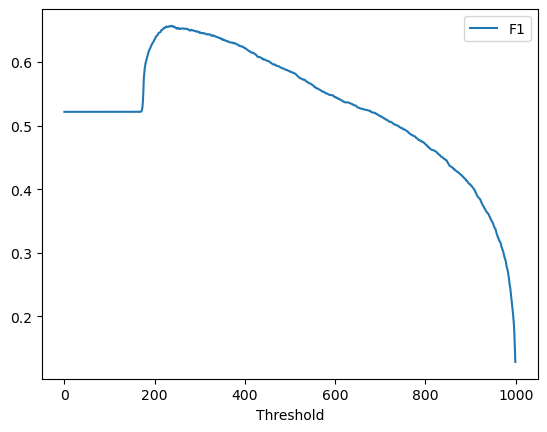

In [50]:
fig, ax = plt.subplots()
plt.plot(F1DF["Threshold"], F1DF["F1"])
plt.xlabel("Threshold")
plt.ylabel("F1")
plt.grid(visible = True)
plt.show()
fig.savefig("testFig", transparent = True)

In [51]:
F1DF.iloc[F1DF["F1"].idxmax()]

Threshold    237.000000
Precision      0.578106
Recall         0.759615
F1             0.656547
Name: 237, dtype: float64

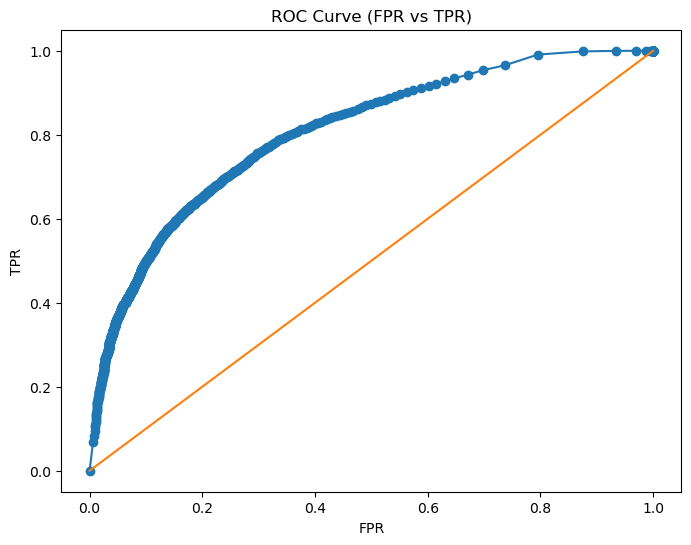

In [52]:
import matplotlib.pyplot as plt

rocaucDF = pd.DataFrame(columns=["Threshold", "TPR", "FPR"])
acc = []

for threshold in range(1001): 
    tempDF = fullResultsDF.copy()
    tempDF["Prediction"] = tempDF["Prediction"].apply(lambda x: x[1] > threshold / 1000)
    TP = ((tempDF["Prediction"] == 1) & (tempDF["Classification"] == 1)).sum()
    FP = ((tempDF["Prediction"] == 1) & (tempDF["Classification"] == 0)).sum()
    FN = ((tempDF["Prediction"] == 0) & (tempDF["Classification"] == 1)).sum()
    TN = ((tempDF["Prediction"] == 0) & (tempDF["Classification"] == 0)).sum()

    TPR = TP / (TP + FN) 
    FPR = FP / (FP + TN) 
    acc.append((TP + TN)/(TP+FP+FN+TN))

    temp = pd.DataFrame({"Threshold": threshold, "TPR": TPR, "FPR": FPR}, index=[0])
    rocaucDF = pd.concat([rocaucDF, temp], ignore_index=True)

In [ ]:
ref_x = [0,1]
ref_y = [0,1]
fig = plt.figure(figsize=(8, 6))
plt.plot(rocaucDF["FPR"], rocaucDF["TPR"], marker='o')
plt.plot(ref_x, ref_y)
plt.title('ROC Curve (FPR vs TPR)')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid(visible = True)
plt.show()
fig.savefig("testFig", transparent = True)

In [53]:
fullResultsDF["Classification"].mean()

0.35276201024505055

In [54]:
1-groundTruthDataframe["Classification"].mean()

0.6472379897549494

In [55]:
(fullResultsDF["Prediction"].apply(lambda x: x[0] + x[1]) - 1).apply(lambda x: max(x,0)).mean()

1.4001381054900655e-08

In [56]:
fullResultsDF[fullResultsDF["Prediction"].apply(lambda x: np.argmax(x)) == fullResultsDF["Classification"]]["Classification"].mean()

0.22588902093427188

In [57]:
max(acc)

0.7612487885919977

In [58]:
F1DF.iloc[500]

Threshold    500.000000
Precision      0.736952
Recall         0.484890
F1             0.584921
Name: 500, dtype: float64

In [59]:
fullResultsDF["Prediction"].apply(lambda x: x[1] > 400/1000).sum()

4031

In [60]:
(rocaucDF["TPR"] / rocaucDF["FPR"]).fillna(0).idxmax()

983

In [61]:
(rocaucDF["TPR"] / rocaucDF["FPR"]).fillna(0).max()

11.904003139717426

In [62]:
rocaucDF

,Threshold,TPR,FPR
0,0,1.000000,1.000000
1,1,1.000000,1.000000
2,2,1.000000,1.000000
3,3,1.000000,1.000000
4,4,1.000000,1.000000
...,...,...,...
996,996,0.104592,0.009305
997,997,0.095369,0.008770
998,998,0.083595,0.007380
999,999,0.069466,0.006203


In [63]:
rocaucDF = pd.DataFrame(columns=["Threshold", "TPR", "FPR"])
acc = []

tempDF = fullResultsDF.copy()
tempDF["Prediction"] = tempDF["Prediction"].apply(lambda x: np.argmax(x))
TP = ((tempDF["Prediction"] == 1) & (tempDF["Classification"] == 1)).sum()
FP = ((tempDF["Prediction"] == 1) & (tempDF["Classification"] == 0)).sum()
FN = ((tempDF["Prediction"] == 0) & (tempDF["Classification"] == 1)).sum()
TN = ((tempDF["Prediction"] == 0) & (tempDF["Classification"] == 0)).sum()

TPR = TP / (TP + FN) 
FPR = FP / (FP + TN) 

print(TPR, FPR)

0.4848901098901099 0.09433155080213904


In [64]:
def displayImage(s3FilePath, fileInfo, resultsDF, localStore, resizeFactor = 2):
    s3.download_file(s3_bucket_name, s3FilePath + fileInfo["File"], localStore + fileInfo["File"])
    print("File: " + fileInfo["File"][:fileInfo["File"].find(".wav") + 4])
    print("Time start (s): " + str(fileInfo["Start"]))
    print("Time start (h:mm:ss): " + str(int(fileInfo["Start"]/60/60)) + ":" + str(int(fileInfo["Start"]/60%60)) + ":" + str(int(fileInfo["Start"]%60%60)))
    print("Time end (s): " + str(fileInfo["End"]))
    print("Time end (h:mm:ss): " + str(int(fileInfo["End"]/60/60)) + ":" + str(int(fileInfo["End"]/60%60)) + ":" + str(int(fileInfo["End"]%60%60)))
    if(resultsDF.iloc[resultsDF.isin([fileInfo["File"]]).any(axis=1).idxmax()]["Classification"] == 1):
        print("Call present: Yes")
    else:
        print("Call present: No")
    print("Predicted probability no: " + str(resultsDF.iloc[resultsDF.isin([fileInfo["File"]]).any(axis=1).idxmax()]["Prediction"][0]*100))
    print("Predicted probability yes: " + str(resultsDF.iloc[resultsDF.isin([fileInfo["File"]]).any(axis=1).idxmax()]["Prediction"][1]*100))
    print("Prediction w/ threshold of max f1: " + str(resultsDF.iloc[resultsDF.isin([fileInfo["File"]]).any(axis=1).idxmax()]["Prediction"][1] > 790/1000))
    with Image.open(localStore + fileInfo["File"]) as im:
        im.resize((im.width * resizeFactor, im.height * resizeFactor)).show()
    os.remove(localStore + fileInfo["File"])

File: 6805.230201090825_processed.wav
Time start (s): 44.79840716774515
Time start (h:mm:ss): 0:0:44
Time end (s): 51.19817962028017
Time end (h:mm:ss): 0:0:51
Call present: No
Predicted probability no: 82.36034512519836
Predicted probability yes: 17.639654874801636
Prediction w/ threshold of max f1: False


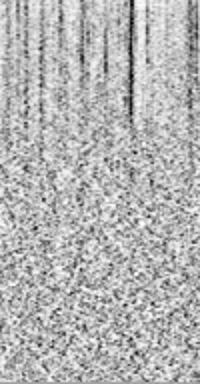

In [65]:
displayImage("trainGreyscale/images/", fullResultsDF.iloc[7], fullResultsDF, "Local_image_store/")

# RUN THE BELOW IF ALL YOU WANT IS PREDICTIONS ON NEW FILES

In [68]:
s3_prediction_output_path = "Outputs/NoAnnotationTestOutput/"
s3_time_stamps = "noAnnotationTest/result_lst.lst"
local_prediciton_temp_store = "Local_prediction_store"
s3_bucket_name = "summer2024-sagemaker-data-bucket"


import pandas as pd
import boto3
import os
import json
import numpy as np
from PIL import Image

In [69]:
KEYS = "ajarriet_accessKeys.csv" # change to your path
    
keyInfo = pd.read_csv(KEYS)

# Create a boto3 resource with your credentials
s3 = boto3.client("s3")

In [70]:
def getPreds(s3PredDir, localStore, bucketName):
    readAllResults = False
    resultsDataframe = pd.DataFrame(columns = ["File", "Prediction"])

    response = s3.list_objects_v2(
        Bucket= bucketName,
        Prefix= s3PredDir,
        StartAfter = s3PredDir)

    while not readAllResults:
        print(response['IsTruncated'])

        readAllResults = not response['IsTruncated']
        finalKey = ""
        for content in response.get('Contents', []):
            #print(content["Key"])
            s3.download_file(bucketName,content["Key"], localStore + "/" + content["Key"].split("/")[-1])
            f = open(localStore + "/" + content["Key"].split("/")[-1], "r")
            temp = pd.DataFrame({"File" : content["Key"].split("/")[-1][:-4], "Prediction" : [json.loads(f.read())["prediction"]]})
            resultsDataframe = pd.concat([resultsDataframe, temp], ignore_index=True)
            os.remove(localStore + "/" + content["Key"].split("/")[-1])
            finalKey = content["Key"]

        if not response['IsTruncated']:
            break

        response = s3.list_objects_v2(
            Bucket = bucketName,
            Prefix = s3PredDir,
            StartAfter = finalKey)
    return resultsDataframe

In [71]:
def compileResultsVerbose(resultsDF, localStore, threshold = -1):
    file = open(localStore + "/verboseResults.txt", "w")
    resultsDF = resultsDF.sort_values(by = ["File", "Start"])
    for index, data in resultsDF.iterrows():
        file.write("--------------------------------\nFile: " + data["File"][:data["File"].find(".wav") + 4] + "\n")
        file.write("Time start (s): " + str(data["Start"]) + "\n")
        file.write("Time start (hh:mm:ss): {:02d}:{:02d}:{:02d}\n".format(int(data["Start"]/60/60), int(data["Start"]/60%60), int(data["Start"]%60%60)))
        file.write("Time end (s): " + str(data["End"]) + "\n")
        file.write("Time start (hh:mm:ss): {:02d}:{:02d}:{:02d}\n".format(int(data["End"]/60/60), int(data["End"]/60%60), int(data["End"]%60%60)))
        file.write("Predicted probability no: " + str(data["Prediction"][0]*100) + "\n")
        file.write("Predicted probability no: " + str(data["Prediction"][1]*100) + "\n")
        if threshold > 0 and threshold < 1:
            if data["Prediction"][1] > threshold:
                file.write("Prediction w/ threshold of " + str(threshold) + ": Yes\n")
            else:
                file.write("Prediction w/ threshold of " + str(threshold) + ": No\n")
    file.close()

In [110]:
def compileResults(resultsDF, localStore, threshold = .5):
    if threshold < 0 or threshold > 1:
        print("Invalid threshold, must be between 0 and 1")
    file = open(localStore + "/compiledResults.txt", "w")
    currStart = -1
    currEnd = 0
    avgProb = 0
    currFile = ""
    i = 0
    file.write("The threshold for this file is " + str(threshold) + "\n")
    resultsDF = resultsDF.set_index(keys = [resultsDF["File"].apply(lambda x: x[:x.find(".wav")+4]), "Start"], drop=False)
    resultsDF = resultsDF.sort_index()
    for index, data in resultsDF.iterrows(): # Want to combine sequential segments
        i = i+1
        if data["File"][:data["File"].find(".wav") + 4] != currFile:
            if currStart != -1:
                print("some")
                currEnd = resultsDF[resultsDF["File"].apply(lambda x: x[:x.find(".wav")+4] == currFile)]["End"].max()
                print("Time (hh:mm:ss) {:02d}:{:02d}:{:02d} to {:02d}:{:02d}:{:02d} is predicted to have calls with a probability of {:.2f}\n".format(int(currStart/60/60), int(currStart/60%60), int(currStart%60%60), int(currEnd/60/60), int(currEnd/60%60), int(currEnd%60%60), avgProb))
                file.write("Time (hh:mm:ss) {:02d}:{:02d}:{:02d} to {:02d}:{:02d}:{:02d} is predicted to have calls with a probability of {:.2f}\n".format(int(currStart/60/60), int(currStart/60%60), int(currStart%60%60), int(currEnd/60/60), int(currEnd/60%60), int(currEnd%60%60), avgProb))
            else:
                print("else")
                currStart = currEnd
                currEnd = resultsDF[resultsDF["File"].apply(lambda x: x[:x.find(".wav")+4] == currFile)]["End"].max()
                #file.write("Time (hh:mm:ss) {:02d}:{:02d}:{:02d} to {:02d}:{:02d}:{:02d} is predicted to NOT have calls with a probability of {:.2f}\n".format(int(currEnd/60/60), int(currEnd/60%60), int(currEnd%60%60), int(currStart/60/60), int(currStart/60%60), int(currStart%60%60), 1-avgProb))
            currStart = -1
            currEnd = 0
            file.write("-----------------------------------\nFile: " + data["File"][:data["File"].find(".wav") + 4] + "\n")
            currFile = data["File"][:data["File"].find(".wav") + 4]
        if data["Prediction"][1] > threshold and currStart == -1:
            currStart = data["Start"]
            #file.write("Time (hh:mm:ss) {:02d}:{:02d}:{:02d} to {:02d}:{:02d}:{:02d} is predicted to NOT have calls with a probability of {:.2f}\n".format(int(currEnd/60/60), int(currEnd/60%60), int(currEnd%60%60), int(currStart/60/60), int(currStart/60%60), int(currStart%60%60), 1-avgProb))
            avgProb = data["Prediction"][1]
            i=0
        elif data["Prediction"][1] > threshold and currStart != -1:
            avgProb = ((avgProb * i) + data["Prediction"][1])/(i+1)
            continue
        elif data["Prediction"][1] < threshold and currStart != -1:
            currEnd = data["End"]
            file.write("Time (hh:mm:ss) {:02d}:{:02d}:{:02d} to {:02d}:{:02d}:{:02d} is predicted to have calls with a probability of {:.2f}\n".format(int(currStart/60/60), int(currStart/60%60), int(currStart%60%60), int(currEnd/60/60), int(currEnd/60%60), int(currEnd%60%60), avgProb))
            currStart = -1
            avgProb = data["Prediction"][1]
            i=0
        elif data["Prediction"][1] < threshold and currStart == -1:
            avgProb = ((avgProb * i) + data["Prediction"][1])/(i+1)
            continue
    if currStart != -1:
        print("some")
        currEnd = resultsDF["End"].max()
        file.write("Time (hh:mm:ss) {:02d}:{:02d}:{:02d} to {:02d}:{:02d}:{:02d} is predicted to have calls with a probability of {:.2f}\n".format(int(currStart/60/60), int(currStart/60%60), int(currStart%60%60), int(currEnd/60/60), int(currEnd/60%60), int(currEnd%60%60), avgProb))
    else:
        print("else")
        currStart = currEnd
        currEnd = resultsDF["End"].max()
        #file.write("Time (hh:mm:ss) {:02d}:{:02d}:{:02d} to {:02d}:{:02d}:{:02d} is predicted to NOT have calls with a probability of {:.2f}\n".format(int(currEnd/60/60), int(currEnd/60%60), int(currEnd%60%60), int(currStart/60/60), int(currStart/60%60), int(currStart%60%60), 1-avgProb))
    file.close()

In [73]:
def compileResultsRaven(resultsDF, localStore, threshold = .5): #IDK if this is worth doing
    return

In [74]:
resultsDF1 = getPreds(s3_prediction_output_path, local_prediciton_temp_store, s3_bucket_name)
s3.download_file(s3_bucket_name, s3_time_stamps, local_prediciton_temp_store + "/timestamps.csv")

timeStamps = pd.read_csv(local_prediciton_temp_store + "/timestamps.csv", sep = "\t", names = ["index", "File", "Start", "End"])

timeStamps["File"] = timeStamps["File"].str.split("/").apply(lambda x: x[-1])
fullResultsDF1 = pd.merge(left = resultsDF1, right = timeStamps)

False


In [75]:
fullResultsDF1

,File,Prediction,index,Start,End
0,6805.230522001009_processed.wav_1.png,"[0.7083271145820618, 0.29167288541793823]",1,0.000000,6.399772
1,6805.230522001009_processed.wav_10.png,"[0.686847984790802, 0.3131519854068756]",10,57.597952,63.997725
2,6805.230522001009_processed.wav_100.png,"[0.6988726258277893, 0.3011273741722107]",100,633.577473,639.977245
3,6805.230522001009_processed.wav_101.png,"[0.6903382539749146, 0.30966171622276306]",101,639.977245,646.377018
4,6805.230522001009_processed.wav_102.png,"[0.6948035955429077, 0.3051963448524475]",102,646.377018,652.776790
...,...,...,...,...,...
557,6805.230522004009_processed.wav_558.png,"[0.6946178674697876, 0.3053821623325348]",558,1766.337199,1772.736972
558,6805.230522004009_processed.wav_559.png,"[0.6881067752838135, 0.31189319491386414]",559,1772.736972,1779.136744
559,6805.230522004009_processed.wav_560.png,"[0.6934952735900879, 0.3065047562122345]",560,1779.136744,1785.536517
560,6805.230522004009_processed.wav_561.png,"[0.6909915208816528, 0.30900850892066956]",561,1785.536517,1791.936289


In [76]:
compileResultsVerbose(fullResultsDF1, local_prediciton_temp_store)

In [111]:
compileResults(fullResultsDF1, local_prediciton_temp_store, .3)

else
some
Time (hh:mm:ss) 00:29:26 to 00:29:58 is predicted to have calls with a probability of 0.31

some
